In [34]:
using Base: @kwdef
using Parameters: @unpack
using Plots
using LinearAlgebra

In [35]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct DESParameter{FT}
    td::FT = 2e-2
    tr::FT = 2e-3
end

@kwdef mutable struct DES{FT}
    param::DESParameter = DESParameter{FT}()
    N::UInt32 # ニューロンの数
    r_double::Vector{FT} = zeros(N)
    hr::Vector{FT} = zeros(N)
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function DESupdate!(variable::DES, param::DESParameter, r_double, hr, spike, dt)
    @unpack N = variable
    @unpack td, tr = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        r_double[i] = r_double[i]*(1-dt/tr) + hr[i]*dt
        hr[i] = hr[i]*(1-dt/td) + spike/(tr*td)
    end
end

DESupdate! (generic function with 3 methods)

In [36]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct CurrentLIFParameter{FT}
    tref::FT = 5e-3 #不応期(ms)
    tc_m::FT = 1e-2 # 膜時定数(ms)
    vrest::FT = -65 # 静止膜電位(mV)
    vreset::FT = -60 # リセット電位(mV)
    vthr::FT = -40 # 閾膜電位(mV)
    vpeak::FT = 30 # ピーク電位(mV)
end

@kwdef mutable struct CurrentLIF{FT}
    param::CurrentLIFParameter = CurrentLIFParameter{FT}()
    N::UInt32 # ニューロンの数
    v::Vector{FT} = fill(-65.0, N) # 膜電位(mV)
    v_::Vector{FT} = fill(-65.0, N) # 発火電位も記録する変数
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻(ms)
    tcount::FT = 0 # 時間カウント
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function cupdate!(variable::CurrentLIF, param::CurrentLIFParameter, I::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref)) * ((vrest - v[i] + I[i]) / tc_m)
    end
    @inbounds @simd for i = i:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i])
        v[i] = ifelse(fire[i], vreset, v[i])
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

cupdate! (generic function with 1 method)

In [50]:
dt, T = 1e-4, 1 # タイムステップ, シミュレーション時間 (sec)
nt = Int(T/dt) # シミュレーションの総ステップ
num_in = 10
num_out = 1

# 入力のポワソンスパイク
fr_in = 30
#spikes = rand(nt, num_in) .< fr_in*dt
spikes = ifelse.(rand(nt, num_in) .< fr_in*dt, 1, 0)
W = 0.2*rand(num_out,num_in)

# modelの定義
neurons = CurrentLIF{Float64}(N=num_out)
synapses = DES{Float64}(N=num_out)

# 記録用
current = zeros(Float64, num_out, nt)
voltage = zeros(Float64, num_out, nt)

r_double = zeros(Float64, num_out)
hr = zeros(Float64, num_out)

@time for t in 1:nt-1
    DESupdate!(synapses, synapses.param, r_double, hr, dot(W,spikes[t,:]), dt)
    current[:,t] = synapses.r_double 
    
    cupdate!(neurons, neurons.param, synapses.r_double, dt)
    neurons.tcount += 1
    voltage[:,t] = neurons.v_  
    
    # ここの更新だけ必要になってくるので注意する必要性がある。　
    r_double = synapses.r_double 
    hr = synapses.hr
end 

  0.023012 seconds (246.91 k allocations: 5.598 MiB)


In [51]:
using LinearAlgebra
100*dot(W,spikes[2,:])

0.0

In [52]:
current

1×10000 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  36.2706  36.1353  35.9984  0.0

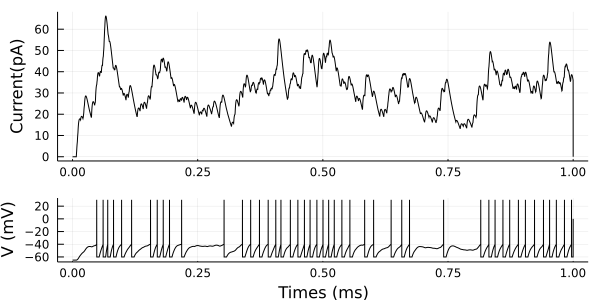

In [53]:
t = Array{Float32}(1:nt)*dt
p1 = plot(t, current[1, :], color="black")
p2 = plot(t, voltage[1, :], color="black")
plot(p1, p2, 
    xlabel = ["" "Times (ms)"], 
    ylabel= ["Current(pA)"　"V (mV)"],
    layout = grid(2, 1, heights=[0.7, 0.3]), legend=false, size=(600,300))